## CS579 Project II Machine Learning Approach Road Map

Author: Christopher Hong

* [Step 1](#1): Machine Learning Business Problem
* [Step 2](#2): Goal of Business Problem
* [Step 3](#3): Data collection
* [Step 4](#4): Data perparation
    * [Step 4.1](#4.1): Loading data
    * [Step 4.2](#4.2): EDAing data 
    * [Step 4.3](#4.3): Partitining data
    * [Step 4.4](#4.4): Wrangling data
* [Step 5](#5): Feature engineering
    * [Step 5.1](#5.1): Engineering text
    * [Step 5.2](#5.2): Vectorizing text
    * [Step 5.3](#5.3): Selecting feature
    * [Step 5.4](#5.4): Reducing dimensionality
* [Step 6](#6): Data analysis
    * [Step 6.1](#6.1): Analyzing title distribution
    * [Step 6.2](#6.2): Analyzing key words
* [Step 7](#7): Model selection
    * [Step 7.1](#7.1): Evaluating Random Forest

**Note**: Setup correct `file path` in `Step4.1` for this notebook to run.

<a id='0'></a>
## 0 Workspace setup

In [1]:
# Common libraries
import pandas as pd
import numpy as np
import os

# Visualization packages
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=16)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
import seaborn as sns
from wordcloud import WordCloud
from wordcloud import STOPWORDS

# NLP processing packages
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Statistical testing packages
import statsmodels.api as sm
import scipy

# Machine Learning packages
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Aesthetic setting
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

# Reproducibility setting
np.random.seed(2020)
random_state = 2020

# Path to Google Drive if run on Google Colab
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


<a id='1'></a>
## 1 Machine Learning Business Problem

In this project, the main question of interest is, given the title of a fake news article A and the title of a coming news article B, to classify B into one of the three categories:
* `agreed`: B talks about the same fake news as A.
* `disagreed`: B refutes the fake news in A.
* `unrelated`: B is unrelated to A.

<a id='2'></a>
## 2 Goal of the Machine Learning Problem

The goal of this project is to `build a model` using Machine Learning algorithms that solves the above mentioned business problem. 

<a id='3'></a>
## 3 Data Collection

The train and test data are provided as `train.csv` and `test.csv`, respectively. 

The columns in train and test data are as follows:
* `id`: the id of each news pair.
* `tid1`: the id of fake news title 1.
* `tid2`: the id of news title 2.
* `title1_en`: the fake news title 1 in English.
* `title2_en`: the news title 2 in English.
* `label`: indicates the relation between the news pair: `agreed, disagreed or unrelated`.

Note: column `label` is excluded from the test data.

<a id='4'></a>
## 4 Data Preparation

<a id='4.1'></a>
### 4.1 Loading Train & Test data

#### Setting up path to `train` data

**Note**: Assume `/content/drive/MyDrive/CS579_Projct_2/option1-data`, which contains `train.csv, test.csv and sample_submission.csv`, exists.

In [2]:
# Define the base dir to local Google Drive
BASE_PATH = "/content/drive/MyDrive/CS579_Project_2/"

# Define base dir to local drive
DATA_PATH = os.path.join(BASE_PATH, "option1-data")

# Create file paths if not extists
os.makedirs(BASE_PATH, exist_ok=True)
os.makedirs(DATA_PATH, exist_ok=True)

# Define dir to train data
TRAIN_DATA_PATH = os.path.join(DATA_PATH, "train.csv")

# Define dir to test data
TEST_DATA_PATH = os.path.join(DATA_PATH, "test.csv")

print("train data path:", TRAIN_DATA_PATH)
print("test data path:", TEST_DATA_PATH)

train data path: /content/drive/MyDrive/CS579_Project_2/option1-data/train.csv
test data path: /content/drive/MyDrive/CS579_Project_2/option1-data/test.csv


#### Loading the data using `pandas`

In [3]:
# Load train data
df_train = pd.read_csv(TRAIN_DATA_PATH)

# Load test data
df_test = pd.read_csv(TEST_DATA_PATH)

<a id='4.2'></a>
### 4.2 EDAing Data Structure

#### Top five rows

In [4]:
# Train data
df_train.head()

,id,tid1,tid2,title1_en,title2_en,label
0,195611,0,1,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
1,191474,2,3,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
2,25300,2,4,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated
3,123757,2,8,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP overtakes Hong Kong? Bureau of ...,unrelated
4,141761,2,11,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outpaces Hong Kong? Defending R...,unrelated


In [5]:
# Test data
df_test.head()

,id,tid1,tid2,title1_en,title2_en
0,256442,100672,100673,"The great coat brother Zhu Zhu Wen, in the man...","Lin xinsheng after the birth of ""hard milking,..."
1,256443,162269,162270,NASA reveals facts about UFO wreckage found on...,"The UFO found in Yuancun, Jiaocheng County, Sh..."
2,256444,157826,157854,The hollow tomatoes are loaded with hormones.,"Li chenfan bingbing home photos, netizen: this..."
3,256445,109579,74076,Ange Pavilion Geoshui: How accurate is Matrimo...,Master one: the eight-character presumption of...
4,256446,15068,15085,A 50-year-old bus-bus blows up an 8-year-old c...,< i > Joe Johnson's disgruntled timing and ord...


In [6]:
print('train data: {:,d} entries, {} attributes'.format(*df_train.shape))
print('test data: {:,d} entries, {} attributes'.format(*df_test.shape))

train data: 256,442 entries, 6 attributes
test data: 64,110 entries, 5 attributes


#### Data description

In [7]:
# Train data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256442 entries, 0 to 256441
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         256442 non-null  int64 
 1   tid1       256442 non-null  int64 
 2   tid2       256442 non-null  int64 
 3   title1_en  256442 non-null  object
 4   title2_en  256442 non-null  object
 5   label      256442 non-null  object
dtypes: int64(3), object(3)
memory usage: 11.7+ MB


In [8]:
# Test data
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64110 entries, 0 to 64109
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         64110 non-null  int64 
 1   tid1       64110 non-null  int64 
 2   tid2       64110 non-null  int64 
 3   title1_en  64110 non-null  object
 4   title2_en  64110 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.4+ MB


In [9]:
# Check duplicates on train data
df_train.duplicated().sum()

0

In [10]:
# Check duplicates on test data
df_test.duplicated().sum()

0

In [11]:
# Categories of label
df_train.label.unique()

array(['unrelated', 'agreed', 'disagreed'], dtype=object)

* No missing values
* No duplicated rows
* Numerical columns: `id, tid1, tid2`
* Text columns: `title1_en, title2_en`
* Categorical column: `label`

#### Data statistics

In [12]:
# Train data
df_train.describe().astype(int)

,id,tid1,tid2
count,256442,256442,256442
mean,128220,85063,69712
std,74028,48402,45481
min,0,0,1
25%,64110,44052,30619
50%,128220,85487,63750
75%,192330,127504,105255
max,256441,167563,167557


In [13]:
# Test data
df_test.describe().astype(int)

,id,tid1,tid2
count,64110,64110,64110
mean,288496,85004,69797
std,18507,48392,45498
min,256442,2,3
25%,272469,44000,30689
50%,288496,85079,63821
75%,304523,127297,105491
max,320551,167562,167558


In [14]:
test_size = np.round(len(df_test) / len(df_train), 2)
print('Ratio of test over train data: {:.0f}%'.format(test_size * 100))

Ratio of test over train data: 25%


In [15]:
# Train label distribution
train_dist = np.round(df_train['label'].value_counts() / len(df_train) * 100, 2)
train_dist

unrelated    68.47
agreed       28.95
disagreed     2.58
Name: label, dtype: float64

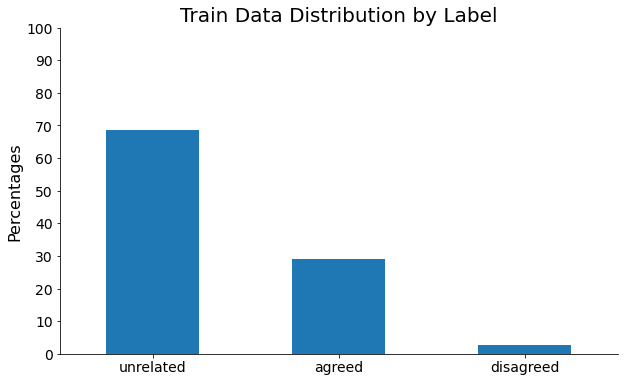

In [16]:
plt.figure(figsize=(10,6))
ax = train_dist.plot(kind='bar', rot=0, ylabel="Percentages", ylim=(0,100))
plt.title("Train Data Distribution by Label", fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.yticks(range(0, 101, 10))
plt.show()

* The case number range from `0 - 256441` for the train data, while `256442 - 320551` for the test one.
* There are `167,564` fake news titles (`tid1`), `167,557` news titles (`tid2`) in the train data.
* There are `167,561` fake news titles (`tid1`), `167,556` news titles (`tid2`) in the test data.
* The ratio of the train data over the test one is about `25%`.
* The majority of the label belongs to `unrelated`.

<a id='4.3'></a>
### 4.3 Partitioning Train Data

In [17]:
# Split the train data into 75/25 train and validation, respectively
test_size= 0.25

# Stratified random sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
for train_index, val_index in split.split(df_train, df_train['label']):
    data_train = df_train.loc[train_index].copy().reset_index(drop=True)
    data_val = df_train.loc[val_index].copy().reset_index(drop=True)

In [18]:
# Train label distribution after slitting
train_set_dist = np.round(data_train['label'].value_counts() / len(data_train) * 100, 2)
train_set_dist

unrelated    68.47
agreed       28.95
disagreed     2.58
Name: label, dtype: float64

In [19]:
# Validation label distribution
val_set_dist = np.round(data_val['label'].value_counts() / len(data_val) * 100, 2)
val_set_dist

unrelated    68.47
agreed       28.95
disagreed     2.58
Name: label, dtype: float64

In [20]:
# Train, validation and test set size
data_train.shape, data_val.shape, df_test.shape

((192331, 6), (64111, 6), (64110, 5))

In [21]:
# Compare label distribution before and after splitting the train data set
stratified_sampling = pd.DataFrame({
    'label': df_train.label.unique().tolist(),
    'Data Distribution': train_dist.tolist(),
    'Stratified Train Distribution': train_set_dist.tolist(),
    "Stratified Validation Distribution": val_set_dist.tolist()})
stratified_sampling = stratified_sampling.set_index('label')
stratified_sampling

,Data Distribution,Stratified Train Distribution,Stratified Validation Distribution
label,,,
unrelated,68.47,68.47,68.47
agreed,28.95,28.95,28.95
disagreed,2.58,2.58,2.58


In [22]:
def compare_performance(df, title, 
                        ylabel="F1-Score (Percentages)",
                        ylim=(0,100), yticks=False,
                        rot=0, legend=True):
    """
    Plot bar chart to compare model f1 score performance.
    """
    ax = df.T.plot(kind='bar', rot=rot, figsize=(10,6), ylim=ylim)
    plt.title(title, fontsize=18)
    plt.ylabel(ylabel)
    if yticks:
        plt.yticks(range(0, 101, 10))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.grid(axis='y')
    if legend:
        plt.legend(fontsize=10)
    else:
        ax.get_legend().remove()
    plt.show()

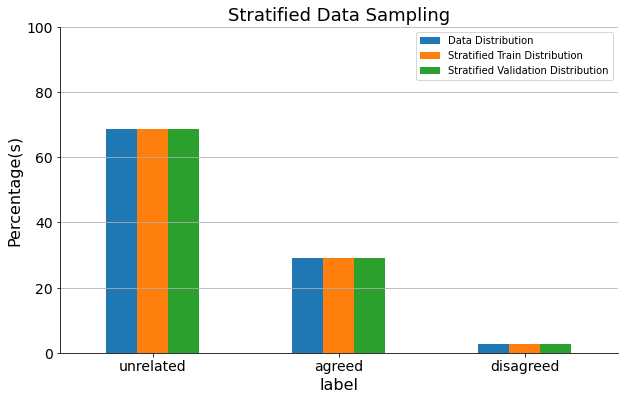

In [23]:
# Plot the label distribution before and after splitting the train data set
title = "Stratified Data Sampling"
ylab = "Percentage(s)"
compare_performance(stratified_sampling.T, title, ylab)

<a id='4.4'></a>
### 4.4 Cleaning  Train Data

#### Diagnosing data dirtiness

In [24]:
# The first sample on attribute title1_en 
data_train.loc[0,'title1_en']

'A few characteristics, let a pregnant mother know the difference between having a boy and having a baby girl!'

In [25]:
# The first sample on attribute title2_en 
data_train.loc[0,'title2_en']

'To share the characteristics of a girl, to have a baby, to have a baby, to have a successful pregnancy, and to follow.'

In [26]:
# Class of the first sample 
data_train.loc[0, 'label']

'unrelated'

* Normalize `title1_en & title2_en`
  * Tokenization
  * lowercasing
  * lemmatization
  * stopwords, punctuation, unwanted tokens removal
  
* Transform `label`

#### Normalizing `title1_en & title2_en` on train data

In [27]:
def normalize_text(text):
    """
    Lowercase, tokenize, lemmatize, 
    remove stop words and unwanted tokens. 
    """
    # Tokenization 
    lower_tokens = word_tokenize(text.lower())
    
    # Retain alphabetic words, i.e. and unwanted tokens
    alpha_tokens = [w for w in lower_tokens if w.isalpha()]
    
    # Create a lemmatizer object
    wordnet_lemmatizer = WordNetLemmatizer()
    
    # Lemmatize all tokens into a new list: lemmatized
    lemmatized = [wordnet_lemmatizer.lemmatize(w) for w in alpha_tokens]
    
    # Create a set of stop words
    stop_words = set(stopwords.words('english'))
    
    # Remove stop words and word length less than 3
    no_stops = [w for w in lemmatized if len(w) > 2 and w not in stop_words]
    
    return ' '.join(no_stops)

In [28]:
data_train['title1_en_normalized'] = data_train['title1_en'].map(normalize_text)
data_train['title2_en_normalized'] = data_train['title2_en'].map(normalize_text)

In [29]:
# The first sample on normalized title1_en 
data_train.loc[0,'title1_en_normalized']

'characteristic let pregnant mother know difference boy baby girl'

In [30]:
# The first sample on normalized title2_en 
data_train.loc[0,'title2_en_normalized']

'share characteristic girl baby baby successful pregnancy follow'

#### Encloding `label` on train set

In [31]:
# unrelated -> 0, agreed -> 1, disagreed -> 2
target_names = data_train.label.unique().tolist()
lab_2_int = dict(zip(target_names, range(3)))
print(lab_2_int)

# 0 -> unrelated, 1 -> agreed , 2 -> disagreed
int_2_lab = dict(zip(lab_2_int.values(), lab_2_int.keys()))
print(int_2_lab)

{'unrelated': 0, 'agreed': 1, 'disagreed': 2}
{0: 'unrelated', 1: 'agreed', 2: 'disagreed'}


In [32]:
# Encode label
data_train['label_encoded'] = data_train['label'].map(lab_2_int)

# Extract train y label column
y_train = data_train['label_encoded'].copy()

In [33]:
# Raw label distribution
data_train['label'].value_counts()

unrelated    131698
agreed        55678
disagreed      4955
Name: label, dtype: int64

In [34]:
# Encoded label distribution
data_train['label_encoded'].value_counts()

0    131698
1     55678
2      4955
Name: label_encoded, dtype: int64

<a id='5'></a>
## 5 Feature Engineering

<a id='5.1'></a>
### 5.1 Engineering Feature for Text

#### Engineering `title 1&2` Text Length

In [35]:
# Combin normalized title1_en & title2_en
data_train['title_1_2_normalized'] = \
    data_train['title1_en_normalized'].str.cat(data_train['title2_en_normalized'], sep=" ")

# Calculate the length of raw titl1_en & title2_en
data_train['title1_en_length'] = data_train['title1_en'].str.len()
data_train['title2_en_length'] = data_train['title2_en'].str.len()

# Calculate the length of normalized titl1_en & title2_en
data_train['title1_en_normalized_length'] = data_train['title1_en_normalized'].str.len()
data_train['title2_en_normalized_length'] = data_train['title2_en_normalized'].str.len()
data_train['title_en_1_2_normalized_length'] = \
    data_train['title1_en_normalized_length'] + data_train['title2_en_normalized_length'] 

# Data quality check

assert ((data_train['title_1_2_normalized'].str.len() - 1) ==
    (data_train['title1_en_normalized_length'] + 
     data_train['title2_en_normalized_length'])).all()

In [36]:
# Normalized title 1 length distribution
data_train[['title1_en_normalized_length']].describe().astype(int).T

,count,mean,std,min,25%,50%,75%,max
title1_en_normalized_length,192331,61,22,0,45,61,76,1616


In [37]:
# Normalized title 2 length distribution
data_train[['title2_en_normalized_length']].describe().astype(int).T

,count,mean,std,min,25%,50%,75%,max
title2_en_normalized_length,192331,62,23,0,47,62,77,2246


In [38]:
def binning(num):
    """
    Bin the length of text into 4 categories base on statistics of quartitle.
    """
    if num < 47:
        return 1
    elif num < 62:
        return 2
    elif num < 77:
        return 3
    else:
        return 4

In [39]:
# Bin normalized title 1&2 length
data_train['title1_en_normalized_bin'] = data_train['title1_en_normalized_length'] .map(binning)
data_train['title2_en_normalized_bin'] = data_train['title2_en_normalized_length'] .map(binning)

#### Vectorizing normalized `title1&2` using `Bag-of-Words`

In [40]:
# The size of the vocabulary sets to the maximum length of the normalized title 1&2
max_features = data_train['title_1_2_normalized'].str.len().max()
print('Maximum size for normalized title 1&2:', max_features)

Maximum size for normalized title 1&2: 2335


In [41]:
# Initialize a CountVectorizer object
count_vectorizer = CountVectorizer(lowercase=False, max_features=max_features)

# Vectorize the normalized title 1&2
text = 'title_1_2_normalized'
count_train = count_vectorizer.fit_transform(data_train[text]).toarray()

# Initialize a binary CountVectorizer object
binary_vectorizer = CountVectorizer(lowercase=False, max_features=max_features, binary=True)

# Vectorize the normalized title 1&2
binary_train = binary_vectorizer.fit_transform(data_train[text]).toarray()

# Vectorize normalized title1
binary_title1 = binary_vectorizer.transform(data_train['title1_en_normalized'])

# Vectorize normalized title2
binary_title2 = binary_vectorizer.transform(data_train['title2_en_normalized'])

# Vectorization check
binary_title1.shape == binary_title2.shape

True

In [42]:
pd.DataFrame(count_train, columns=count_vectorizer.get_feature_names()).sample(5)

abandon  abandoned  abdomen  abdominal  able  abolished  abortion  \
93951         0          0        0          0     0          0         0   
164552        0          0        0          0     0          0         0   
146520        0          0        0          0     0          0         0   
184776        0          0        0          0     0          0         0   
137891        0          0        0          0     0          0         0   

        abroad  absolutely  abuse  accept  access  accident  accidentally  \
93951        0           0      0       0       0         0             0   
164552       0           0      0       0       0         0             0   
146520       0           0      0       0       0         0             0   
184776       0           0      0       0       0         0             0   
137891       0           0      0       0       0         0             0   

        accordance  according  account  accurate  accused  ache  acid  acne  \
93951            0          0        0         0        0     0     0     0   
164552           0          0        0         0        0     0     0     0   
146520           0          0        0         0        0     0     0     0   
184776           0          0        0         0        0     0     0     0   
137891           0          0        0         0        0     0     0     0   

        acting  action  actor  actress  actually  add  added  addict  adding  \
93951        0       0      0        0         0    0      0       0       0   
164552       0       0      0        0         0    0      0       0       0   
146520       0       0      0        0         0    0      0       0       0   
184776       0       0      0        0         0    0      0       0       0   
137891       0       0      0        0         0    1      0       0       0   

        addition  adhere  adjusted  adjustment  administration  \
93951          0       0         0           0               0   
164552         0       0         0           0               0   
146520         0       0         0           0               0   
184776         0       0         0           0               0   
137891         0       0         0           1               0   

        administrative  admission  admit  admits  admitted  advantage  affair  \
93951                0          0      0       0         0          0       0   
164552               0          0      0       0         0          0       0   
146520               0          0      0       0         0          0       0   
184776               0          0      0       0         0          0       0   
137891               0          0      0       0         0          0       0   

        affect  afford  afraid  afternoon  age  agency  agent  aging  ago  \
93951        0       0       0          0    0       0      0      0    0   
164552       0       0       0          0    0       0      0      0    0   
146520       0       0       0          0    0       0      0      0    0   
184776       0       0       0          0    0       0      0      0    0   
137891       0       0       0          0    0       0      0      0    0   

        agree  agricultural  agriculture  ahead  aid  air  aircraft  airplane  \
93951       0             0            0      0    0    0         0         0   
164552      0             0            0      0    0    0         0         0   
146520      0             0            0      0    0    0         0         0   
184776      0             0            0      0    0    0         0         0   
137891      0             0            0      0    0    0         0         0   

        airport  alarm  alcohol  alert  ali  alien  alipay  alive  alkaline  \
93951         0      0        0      0    0      0       0      0         0   
164552        0      0        0      0    0      0       0      0         0   
146520        0      0        0      0    0      0     

In [43]:
pd.DataFrame(binary_train, columns=binary_vectorizer.get_feature_names()).sample(5)

abandon  abandoned  abdomen  abdominal  able  abolished  abolition  \
56067         0          0        0          0     0          0          0   
122339        0          0        0          0     0          0          0   
71320         0          0        0          0     0          0          0   
49844         0          0        0          0     0          0          0   
181105        0          0        0          0     0          0          0   

        abortion  abroad  absolutely  abuse  abused  accept  access  accident  \
56067          0       0           0      0       0       0       0         0   
122339         0       0           0      0       0       0       0         0   
71320          0       0           0      0       0       0       0         0   
49844          0       0           0      0       0       0       0         0   
181105         0       0           0      0       0       0       0         0   

        accidentally  accordance  according  account  accurate  accused  ache  \
56067              0           0          0        0         0        0     0   
122339             0           0          0        0         0        0     0   
71320              0           0          0        0         0        0     0   
49844              0           0          0        0         0        0     0   
181105             0           0          0        0         0        0     0   

        acid  acne  act  acting  action  actor  actress  actually  add  added  \
56067      0     0    0       0       0      0        0         0    0      0   
122339     0     0    0       0       0      0        0         0    0      0   
71320      0     0    0       0       0      0        0         0    0      0   
49844      0     0    0       0       0      0        0         0    0      0   
181105     0     0    0       0       0      0        0         0    0      0   

        addict  addiction  adding  addition  adhere  adjusted  adjustment  \
56067        0          0       0         0       0         0           0   
122339       0          0       0         0       0         0           0   
71320        0          0       0         0       0         0           0   
49844        0          0       0         0       0         0           0   
181105       0          0       0         0       0         0           0   

        administration  administrative  admission  admit  admits  admitted  \
56067                0               0          0      0       0         0   
122339               0               0          0      0       0         0   
71320                0               0          0      0       0         0   
49844                0               0          0      0       0         0   
181105               0               0          0      0       0         0   

        advantage  affair  affect  afford  afraid  age  agency  agent  aging  \
56067           0       0       0       0       0    0       0      0      0   
122339          0       0       0       0       0    0       0      0      0   
71320           0       0       0       0       0    0       0      0      0   
49844           0       0       0       0       0    0       0      0      0   
181105          0       0       0       0       0    0       0      0      0   

        ago  agree  agricultural  agriculture  ahead  aid  air  aircraft  \
56067     0      0             0            0      0    0    0         0   
122339    0      0             0            0      0    0    0         0   
71320     0      0             0            0      0    0    0         0   
49844     0      0             0            0      0    0    0         0   
181105    1      0             0            0      0    0    0         0   

        airplane  airport  alarm  alcohol  alert  ali  alien  alipay  alive  \
56067          0        0      0        0      0    0      0       0      0   
122339         0        0      0        0      0  

#### Vectorizing normalized `title1&2` using `TF-IDF`

In [44]:
# Initialize a TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer(lowercase=False, max_features=max_features)

# Vectorize the normalized title 1&2
tfidf_train = tfidf_vectorizer.fit_transform(data_train[text]).toarray()

# Vectorize normalized title1
tfidf_title1 = tfidf_vectorizer.transform(data_train['title1_en_normalized'])

# Vectorize normalized title2
tfidf_title2 = tfidf_vectorizer.transform(data_train['title2_en_normalized'])

# Vectorization check
tfidf_title1.shape == tfidf_title2.shape

True

In [45]:
pd.DataFrame(tfidf_train, columns=tfidf_vectorizer.get_feature_names()).sample(5)

abandon  abandoned  abdomen  abdominal  able  abolished  abortion  \
4721        0.0        0.0      0.0        0.0   0.0        0.0       0.0   
190660      0.0        0.0      0.0        0.0   0.0        0.0       0.0   
177278      0.0        0.0      0.0        0.0   0.0        0.0       0.0   
129869      0.0        0.0      0.0        0.0   0.0        0.0       0.0   
62216       0.0        0.0      0.0        0.0   0.0        0.0       0.0   

        abroad  absolutely  abuse  accept  access  accident  accidentally  \
4721       0.0         0.0    0.0     0.0     0.0       0.0           0.0   
190660     0.0         0.0    0.0     0.0     0.0       0.0           0.0   
177278     0.0         0.0    0.0     0.0     0.0       0.0           0.0   
129869     0.0         0.0    0.0     0.0     0.0       0.0           0.0   
62216      0.0         0.0    0.0     0.0     0.0       0.0           0.0   

        accordance  according  account  accurate  accused  ache  acid  acne  \
4721           0.0        0.0      0.0       0.0      0.0   0.0   0.0   0.0   
190660         0.0        0.0      0.0       0.0      0.0   0.0   0.0   0.0   
177278         0.0        0.0      0.0       0.0      0.0   0.0   0.0   0.0   
129869         0.0        0.0      0.0       0.0      0.0   0.0   0.0   0.0   
62216          0.0        0.0      0.0       0.0      0.0   0.0   0.0   0.0   

        acting  action  actor  actress  actually  add  added  addict  adding  \
4721       0.0     0.0    0.0      0.0       0.0  0.0    0.0     0.0     0.0   
190660     0.0     0.0    0.0      0.0       0.0  0.0    0.0     0.0     0.0   
177278     0.0     0.0    0.0      0.0       0.0  0.0    0.0     0.0     0.0   
129869     0.0     0.0    0.0      0.0       0.0  0.0    0.0     0.0     0.0   
62216      0.0     0.0    0.0      0.0       0.0  0.0    0.0     0.0     0.0   

        addition  adhere  adjusted  adjustment  administration  \
4721         0.0     0.0       0.0         0.0             0.0   
190660       0.0     0.0       0.0         0.0             0.0   
177278       0.0     0.0       0.0         0.0             0.0   
129869       0.0     0.0       0.0         0.0             0.0   
62216        0.0     0.0       0.0         0.0             0.0   

        administrative  admission  admit  admits  admitted  advantage  affair  \
4721               0.0        0.0    0.0     0.0       0.0        0.0     0.0   
190660             0.0        0.0    0.0     0.0       0.0        0.0     0.0   
177278             0.0        0.0    0.0     0.0       0.0        0.0     0.0   
129869             0.0        0.0    0.0     0.0       0.0        0.0     0.0   
62216              0.0        0.0    0.0     0.0       0.0        0.0     0.0   

        affect  afford  afraid  afternoon  age  agency  agent  aging  ago  \
4721       0.0     0.0     0.0        0.0  0.0     0.0    0.0    0.0  0.0   
190660     0.0     0.0     0.0        0.0  0.0     0.0    0.0    0.0  0.0   
177278     0.0     0.0     0.0        0.0  0.0     0.0    0.0    0.0  0.0   
129869     0.0     0.0     0.0        0.0  0.0     0.0    0.0    0.0  0.0   
62216      0.0     0.0     0.0        0.0  0.0     0.0    0.0    0.0  0.0   

        agree  agricultural  agriculture  ahead  aid  air  aircraft  airplane  \
4721      0.0           0.0          0.0    0.0  0.0  0.0       0.0       0.0   
190660    0.0           0.0          0.0    0.0  0.0  0.0       0.0       0.0   
177278    0.0           0.0          0.0    0.0  0.0  0.0       0.0       0.0   
129869    0.0           0.0          0.0    0.0  0.0  0.0       0.0       0.0   
62216     0.0           0.0          0.0    0.0  0.0  0.0       0.0       0.0   

        airport  alarm  alcohol  alert  ali  alien  alipay  alive  alkaline  \
4721        0.0    0.0      0.0    0.0  0.0    0.0     0.0    0.0       0.0   
190660      0.0    0.0      0.0    0.0  0.0    0.0     0.0    0.0       0.0   
177278      0.0    0.0      0.0    0.0  0.0    0.0     

<a id='5.2'></a>
### 5.2 Engineering Feature for Vectorized Text

#### Engineering cosine similarity score on binary count vectorized `title 1&2`

In [46]:
data_train['binary_cosine'] = 0.0
for idx in range(len(data_train)):
    cosine = cosine_similarity(binary_title1[idx], binary_title2[idx])
    data_train.loc[idx, 'binary_cosine'] = np.round(cosine[0,0], 2)

#### Engineering cosine similarity score on tfidf vectorized `title 1&2`

In [47]:
data_train['tfidf_cosine'] = 0.0
for idx in range(len(data_train)):
    cosine = cosine_similarity(tfidf_title1[idx], tfidf_title2[idx])
    data_train.loc[idx, 'tfidf_cosine'] = np.round(cosine[0,0], 2)

In [48]:
# Release vectorized title 1 & 2 columns from memory
del binary_title1
del binary_title2
del tfidf_title1
del tfidf_title2

<a id='5.3'></a>
### 5.3 Selecting Feature

#### Selecting Vectorized Features

In [49]:
def kfold_cross_validation(model, 
                           X, 
                           y,
                           n_splits=3,
                           target_names=['unrelated', 'agreed', 'disagreed']):
    """
    Calculate f1-score using K-fold cross-validtion.
    """
    # Create stratified K-fold cross-validator
    skf = StratifiedKFold(n_splits=n_splits, random_state=None)
    # Store K-fold f1-score
    k_f1 = np.array([0.0] * len(target_names))
    # Counter for K
    K = 0
    for train_index, test_index in skf.split(X, y):
        # Construct a new model with the same params
        clone_model = clone(model)
        # Extract train and test data
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        # Fit the model
        clone_model.fit(X_train, y_train)
        # Predict label
        y_pred = clone_model.predict(X_test)
        # Calculate f1-score
        f1 = f1_score(y_test, y_pred, average=None)
        f1 = f1.round(2)
        k_f1 += f1
        K += 1
        # Print report
        print("Fold {} f1-score {}:{} {}:{} {}:{}".format(K,
            target_names[0], f1[0],
            target_names[1], f1[1],
            target_names[2], f1[2]))
    k_f1 = (k_f1 / n_splits).round(2)
    print("Avg. f1-score {}:{} {}:{} {}:{}".format(
        target_names[0], k_f1[0],
        target_names[1], k_f1[1],
        target_names[2], k_f1[2]))
    return k_f1

In [50]:
# Create a DataFrame to store f1-score
df_f1 = pd.DataFrame()

# Create a default multinomial naive bayes model
nb_model = MultinomialNB()

# Create a default logistic regression model
lr_model = LogisticRegression(
    random_state=random_state, 
    multi_class="multinomial",
    solver="lbfgs", 
    C=10)

In [51]:
print('Naive Bayes on count vectorized features:\n')
res = kfold_cross_validation(nb_model, count_train, y_train)
df_f1 = df_f1.append([res], ignore_index=True)

Naive Bayes on count vectorized features:

Fold 1 f1-score unrelated:0.71 agreed:0.55 disagreed:0.24
Fold 2 f1-score unrelated:0.71 agreed:0.54 disagreed:0.24
Fold 3 f1-score unrelated:0.71 agreed:0.54 disagreed:0.24
Avg. f1-score unrelated:0.71 agreed:0.54 disagreed:0.24


In [52]:
print('Naive Bayes on binary vectorized features:\n')
res = kfold_cross_validation(nb_model, binary_train, y_train)
df_f1 = df_f1.append([res], ignore_index=True)

Naive Bayes on binary vectorized features:

Fold 1 f1-score unrelated:0.72 agreed:0.53 disagreed:0.25
Fold 2 f1-score unrelated:0.72 agreed:0.52 disagreed:0.27
Fold 3 f1-score unrelated:0.72 agreed:0.52 disagreed:0.26
Avg. f1-score unrelated:0.72 agreed:0.52 disagreed:0.26


In [53]:
print('Naive Bayes on tfidf vectorized features:\n')
res = kfold_cross_validation(nb_model, tfidf_train, y_train)
df_f1 = df_f1.append([res], ignore_index=True)

Naive Bayes on tfidf vectorized features:

Fold 1 f1-score unrelated:0.81 agreed:0.36 disagreed:0.17
Fold 2 f1-score unrelated:0.81 agreed:0.36 disagreed:0.18
Fold 3 f1-score unrelated:0.81 agreed:0.35 disagreed:0.16
Avg. f1-score unrelated:0.81 agreed:0.36 disagreed:0.17


In [54]:
print('Logistic Regression on count vectorized features:\n')
res = kfold_cross_validation(lr_model, count_train, y_train)
df_f1 = df_f1.append([res], ignore_index=True)

Logistic Regression on count vectorized features:

Fold 1 f1-score unrelated:0.83 agreed:0.54 disagreed:0.3
Fold 2 f1-score unrelated:0.82 agreed:0.54 disagreed:0.29
Fold 3 f1-score unrelated:0.82 agreed:0.54 disagreed:0.27
Avg. f1-score unrelated:0.82 agreed:0.54 disagreed:0.29


In [55]:
print('Logistic Regression on binary vectorized features:\n')
res = kfold_cross_validation(lr_model, binary_train, y_train)
df_f1 = df_f1.append([res], ignore_index=True)

Logistic Regression on binary vectorized features:

Fold 1 f1-score unrelated:0.83 agreed:0.58 disagreed:0.29
Fold 2 f1-score unrelated:0.83 agreed:0.58 disagreed:0.3
Fold 3 f1-score unrelated:0.83 agreed:0.58 disagreed:0.27
Avg. f1-score unrelated:0.83 agreed:0.58 disagreed:0.29


In [56]:
print('Logistic Regression on tfidf vectorized features:\n')
res = kfold_cross_validation(lr_model, tfidf_train, y_train)
df_f1 = df_f1.append([res], ignore_index=True)

Logistic Regression on tfidf vectorized features:

Fold 1 f1-score unrelated:0.83 agreed:0.59 disagreed:0.28
Fold 2 f1-score unrelated:0.83 agreed:0.59 disagreed:0.27
Fold 3 f1-score unrelated:0.83 agreed:0.58 disagreed:0.24
Avg. f1-score unrelated:0.83 agreed:0.59 disagreed:0.26


In [57]:
# Release memboery from count vectors
del count_train

`Logistic Regression` trained on `binary or tfidf vectorized` features has the best performance on all categories of the label.

#### Selecting Continuous Features

In [58]:
def deviance_test(X, y):
    """
    Credit to Prof. Ming Long Lam.
    Perform hypothesis testing on the predictabiliy of 
    a continuous feature on a categorical label.
    Calculate McFadden Sudo Rsquared Score.
    Range from 0 - 1, higher the better.
    """
    # Transform y to categorical data type
    y_cat = y.astype('category')

    # Multinomial logistic model with only the intercept term
    X_intercept = np.where(y_cat.notnull(), 1, 0)
    logit = sm.MNLogit(y_cat, X_intercept)
    results = logit.fit(method='newton', full_output=True, maxiter=100, tol=1e-8)
    params = results.params
    llk0 = logit.loglike(params.values)

#     print(results.summary())
#     print('Model Log-Likelihood:', llk0)
#     print('\n')

    # Multinomial logistic model with the intercept and the interval feature X
    X = sm.add_constant(X, prepend=True)
    logit = sm.MNLogit(y_cat, X)
    results = logit.fit(method='newton', full_output=True, maxiter=100, tol=1e-8)
    params = results.params
    llk1 = logit.loglike(params.values)

#     print(results.summary())
#     print('Model Log-Likelihood:', llk1)
#     print('\n')

    # Calculate the deviance
    deviance_stats = 2.0 * (llk1 - llk0)
    # Calculate the K - 1 degrees of freedom
    deviance_DF = len(y_cat.cat.categories - 1.0)
    # Perform one-sided significance hypothesis testing
    deviance_sig = scipy.stats.chi2.sf(deviance_stats, deviance_DF)
    # Calculate the McFadden Sudo Rsquare score
    mcf_score = 1.0 - (llk1 / llk0)

#     print('Deviance statistic:', deviance_stats)
#     print('Deviance degrees of freedom:', deviance_DF)
#     print('One-side significance probability:', deviance_sig)
    print('McFadden Sudo Rsquare score:', mcf_score)
    print()
    
    return mcf_score

In [59]:
# McFadden score for continuous features
continuous = []

# Test the predictability of cosine similarity score on binary count vectors
continuous.append(deviance_test(data_train[['binary_cosine']], data_train['label_encoded']))

# Test the predictability of cosine similarity score on TFIDF vectors
continuous.append(deviance_test(data_train[['tfidf_cosine']], data_train['label_encoded']))

# Test the predictability of sample case number
continuous.append(deviance_test(data_train[['id']], data_train['label_encoded']))

# Test the predictability of title 1 case numbers
continuous.append(deviance_test(data_train[['tid1']], data_train['label_encoded']))

# Test the predictability of title 2 case numbers
continuous.append(deviance_test(data_train[['tid2']], data_train['label_encoded']))

Optimization terminated successfully.
         Current function value: 0.712442
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.572194
         Iterations 7
McFadden Sudo Rsquare score: 0.19685498127460255

Optimization terminated successfully.
         Current function value: 0.712442
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.582050
         Iterations 7
McFadden Sudo Rsquare score: 0.1830212399442549

Optimization terminated successfully.
         Current function value: 0.712442
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.712440
         Iterations 7
McFadden Sudo Rsquare score: 2.3756693018350816e-06

Optimization terminated successfully.
         Current function value: 0.712442
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.711818
         Iterations 7
McFadden Sudo Rsquare score: 0.0

In [60]:
# Create dataframe for the McFadden score
df_con = pd.DataFrame({'McFadden Score': continuous})
df_con.index = ['Cosine Similarity on Binary Vectors', 'Cosine Similarity on TFIDF Vectors', 'id', 'tid1', 'tid2']
df_con = df_con.round(2)
df_con = df_con.sort_values(by='McFadden Score')

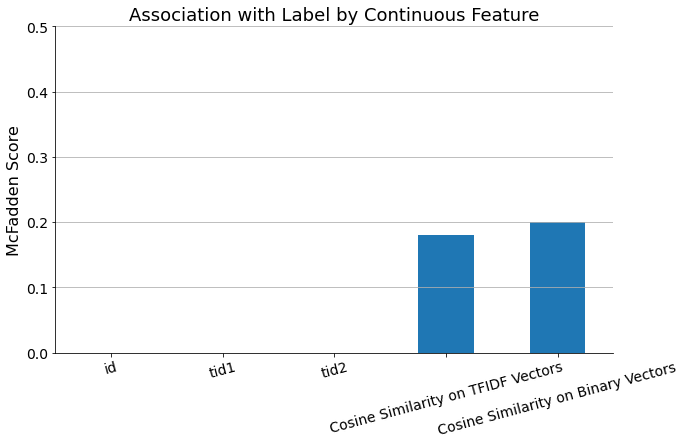

In [61]:
# Plot McFadden Score
title = "Association with Label by Continuous Feature"
ylab = "McFadden Score"
ylim = (0, 0.5)
compare_performance(df_con.T, title, ylab, ylim, rot=15, legend=False)

`Cosine similarity` on binary or TFIDF vectors show `weak` predictability, while none of `id, tid1, or tid2` show any.

#### Selecting Categorical Feature

In [62]:
def chi_sq_test (X, y):
    """
    Credit to Prof. Ming Long Lam.
    Perform hypothesis testing on the assoication of 
    a categorical feature and a categorical label.
    Calculate Cramer's V Score.
    Range from 0 - 1, higher the better.
    """
    X_cat = X.astype('category')
    y_cat = y.astype('category')
    obs_count = pd.crosstab(index = X_cat, columns = y_cat, margins = False, dropna = True)
    c_total = obs_count.sum(axis = 1)
    r_total = obs_count.sum(axis = 0)
    n_total = np.sum(r_total)
    exp_count = np.outer(c_total, (r_total / n_total))

#     print('Observed Count:\n', obs_count)
#     print('Column Total:\n', c_total)
#     print('Row Total:\n', r_total)
#     print('Overall Total:\n', n_total)
#     print('Expected Count:\n', exp_count)
#     print('\n')
       
    chi_stat = ((obs_count - exp_count)**2 / exp_count).to_numpy().sum()
    chi_DF = (obs_count.shape[0] - 1.0) * (obs_count.shape[1] - 1.0)
    chi_sig = scipy.stats.chi2.sf(chi_stat, chi_DF)

    cramerV = chi_stat / n_total
    if (c_total.size > r_total.size):
        cramerV = cramerV / (r_total.size - 1.0)
    else:
        cramerV = cramerV / (c_total.size - 1.0)
    cramerV = np.sqrt(cramerV)

    return cramerV

In [63]:
# cramerV score for categorical veriables
categorical = []

# Chi sq test on normalized title 1 length
categorical.append(chi_sq_test(data_train['title1_en_normalized_bin'], data_train['label_encoded']))

# Chi sq test on normalized title 2 length
categorical.append(chi_sq_test(data_train['title2_en_normalized_bin'], data_train['label_encoded']))

In [64]:
# Create a dataframe for the cramerV score
df_cat = pd.DataFrame(categorical)
df_cat.columns = ["Cramver's V"]
df_cat.index  =['Normalized Title 1 Length', 'Normalized Title 2 Length']
df_cat = df_cat.round(2)
df_cat

,Cramver's V
Normalized Title 1 Length,0.03
Normalized Title 2 Length,0.02


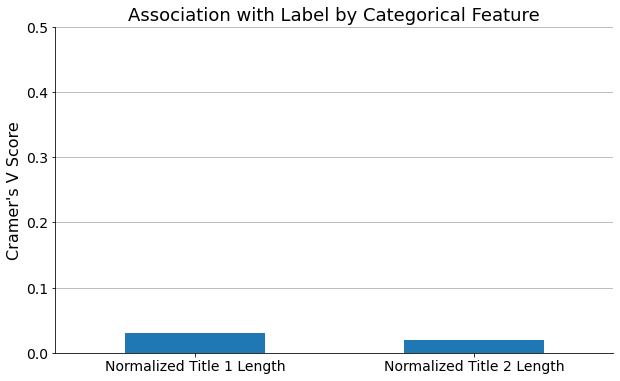

In [65]:
# Plot Cramer's V Score
title = "Association with Label by Categorical Feature"
ylab = "Cramer's V Score"
ylim = (0, 0.5)
compare_performance(df_cat.T, title, ylab, ylim, legend=False)

The Normalized length of title 1 or 2 shows `negligible` assocication with `label`.

#### Selecting Vectorized and Cosine Similarity Feature Combinations

In [66]:
# Combine binary vectors and cosine score
binary_train = pd.concat([pd.DataFrame(binary_train), data_train['binary_cosine']], axis=1)

In [67]:
print('Logistic Regression on binary vectorized and cosine similarity features:\n')
res = kfold_cross_validation(lr_model, binary_train.values, y_train)
df_f1 = df_f1.append([res], ignore_index=True)

Logistic Regression on binary vectorized and cosine similarity features:

Fold 1 f1-score unrelated:0.86 agreed:0.69 disagreed:0.34
Fold 2 f1-score unrelated:0.86 agreed:0.69 disagreed:0.36
Fold 3 f1-score unrelated:0.86 agreed:0.68 disagreed:0.34
Avg. f1-score unrelated:0.86 agreed:0.69 disagreed:0.35


In [68]:
# Combine tfidf vectors and cosine score
tfidf_train = pd.concat([pd.DataFrame(tfidf_train), data_train['tfidf_cosine']], axis=1)

In [69]:
print('Logistic Regression on tfidf vectorized and cosine similary features:\n')
res = kfold_cross_validation(lr_model, tfidf_train.values, y_train)
df_f1 = df_f1.append([res], ignore_index=True)

Logistic Regression on tfidf vectorized and cosine similary features:

Fold 1 f1-score unrelated:0.86 agreed:0.68 disagreed:0.33
Fold 2 f1-score unrelated:0.86 agreed:0.68 disagreed:0.32
Fold 3 f1-score unrelated:0.86 agreed:0.68 disagreed:0.28
Avg. f1-score unrelated:0.86 agreed:0.68 disagreed:0.31


In [70]:
# Release tfidf vectors from memory
del tfidf_train

`Binary vectors` has better performance on Logistic Regression.

<a id='5.4'></a>
### 5.4 Dimensionality Reduction

In [71]:
# Create a pca with 90% variance captured
pca = PCA(n_components=0.7)
binary_train_pca = pca.fit_transform(binary_train)

In [72]:
binary_train_pca.shape, binary_train.shape

((192331, 574), (192331, 2336))

In [73]:
print('Logistic Regression on reduced binary vectorized and cosine similarity features:\n')
res = kfold_cross_validation(lr_model, binary_train_pca, y_train)
df_f1 = df_f1.append([res], ignore_index=True)

Logistic Regression on reduced binary vectorized and cosine similarity features:

Fold 1 f1-score unrelated:0.86 agreed:0.65 disagreed:0.26
Fold 2 f1-score unrelated:0.85 agreed:0.65 disagreed:0.24
Fold 3 f1-score unrelated:0.85 agreed:0.65 disagreed:0.24
Avg. f1-score unrelated:0.85 agreed:0.65 disagreed:0.25


In [74]:
# Formatted dataframe
target_names = ['unrelated', 'agreed', 'disagreed']
models = ['Naive Bayes', 'Logistic Regression']
features = ['Count Vectors', 'Binary Vectors', 'TFIDF Vectors']
idx = []
for m in models:
    for f in features:
        idx.append(m + ' trained on ' + f)
        
models = ['Logistic Regression']
features = [
    'Binary Vectors & Cosine Score', 
    'TFIDF Vectors & Cosine Score',
    'Binary Vectors & Cosine Score w/ Reduced Dim']
for m in models:
    for f in features:
        idx.append(m + ' trained on ' + f)
        
# Set column names
df_f1.columns = target_names

# Set index
df_f1.index = idx

# Set data type
df_f1 = df_f1.mul(100).round(0).astype(int)
df_f1 = df_f1.sort_values(by='disagreed')
df_f1

,unrelated,agreed,disagreed
Naive Bayes trained on TFIDF Vectors,81,36,17
Naive Bayes trained on Count Vectors,71,54,24
Logistic Regression trained on Binary Vectors & Cosine Score w/ Reduced Dim,85,65,25
Naive Bayes trained on Binary Vectors,72,52,26
Logistic Regression trained on TFIDF Vectors,83,59,26
Logistic Regression trained on Count Vectors,82,54,29
Logistic Regression trained on Binary Vectors,83,58,29
Logistic Regression trained on TFIDF Vectors & Cosine Score,86,68,31
Logistic Regression trained on Binary Vectors & Cosine Score,86,69,35


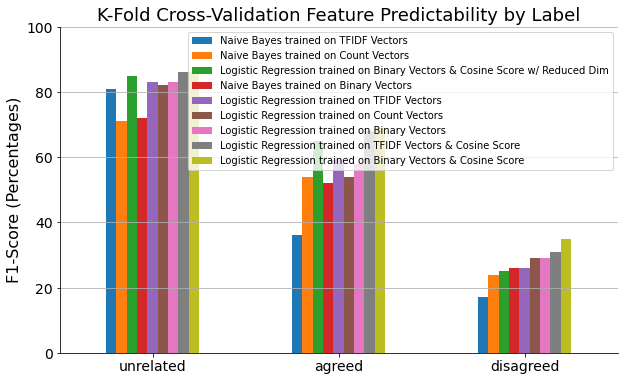

In [75]:
# Plot feature performance
title = "K-Fold Cross-Validation Feature Predictability by Label"
compare_performance(df_f1, title)

In [76]:
# Save feature performance
df_f1.to_csv('feature_per.csv', index=True)

Logistic Regression model trained on `binary` vectorized and cosine similarity features has the `highest` f1-score on all categories of `label`.

<a id='6'></a>
## 6 Data Analyzing

<a id='6.1'></a>
### 6.1 Title 1&2 Length Distribution

In [77]:
titles = [
    'title1_en_length', 'title1_en_normalized_length', 
    'title2_en_length', 'title2_en_normalized_length']
box_size = (13,8)
t_size = 22
xlab = '# Words'

In [78]:
data_train[titles].describe().astype(int)

,title1_en_length,title1_en_normalized_length,title2_en_length,title2_en_normalized_length
count,192331,192331,192331,192331
mean,93,61,94,62
std,32,22,34,23
min,3,0,1,0
25%,73,45,75,47
50%,94,61,95,62
75%,113,76,113,77
max,1752,1616,4002,2246


Text(0.5, 0, '# Words')

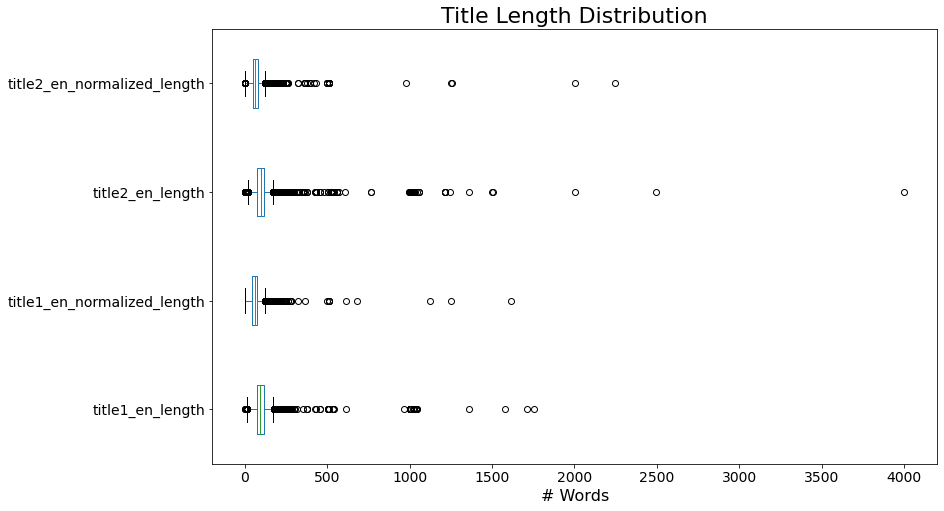

In [79]:
data_train[titles].plot(
    kind='box', 
    vert=False, 
    figsize=box_size)
plt.title("Title Length Distribution", fontsize=t_size)
plt.xlabel(xlab)

`Long-tail` distributon.

Text(0.5, 0, '# Words')

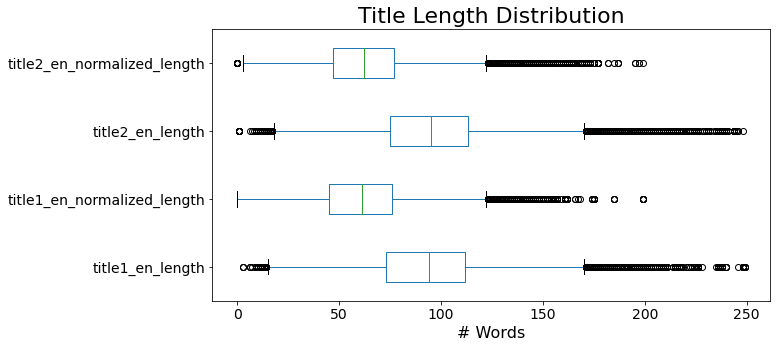

In [80]:
threshold = 250
less250 = data_train.title1_en_length < threshold
less250 &= data_train.title2_en_length < threshold
less250 &= data_train.title1_en_normalized_length < threshold
less250 &= data_train.title2_en_normalized_length < threshold
(data_train[less250])[titles].plot(
    kind='box', 
    vert=False, 
    figsize=(10,5))
plt.title("Title Length Distribution", fontsize=t_size)
plt.xlabel(xlab)

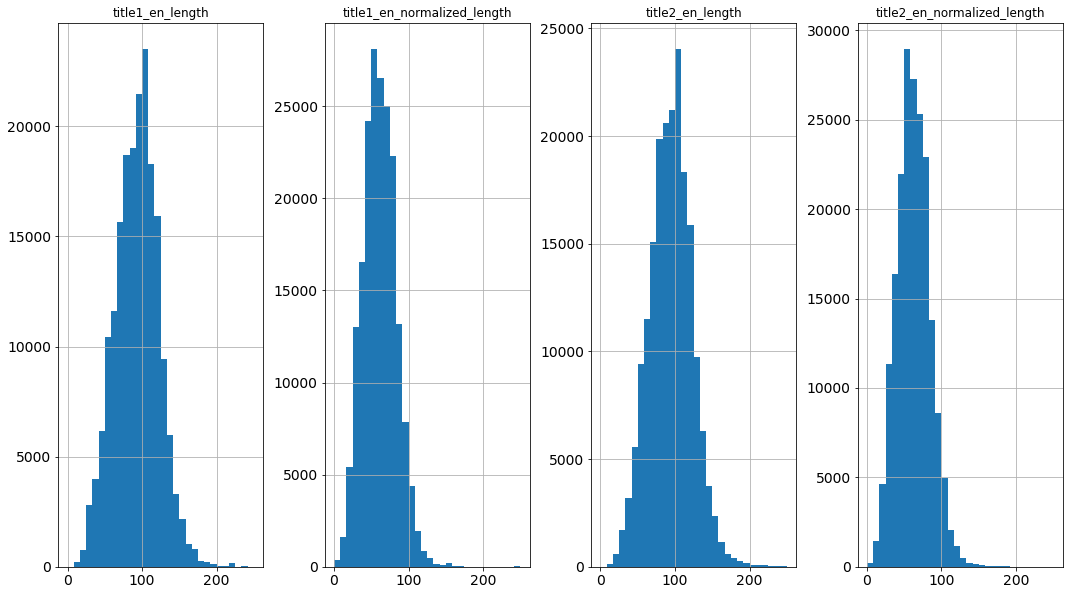

In [81]:
ax = data_train[titles].hist(figsize=(18,10), bins=30, range=(0,250), layout=(1,4))
plt.show()

Text(0.5, 0, '# Words')

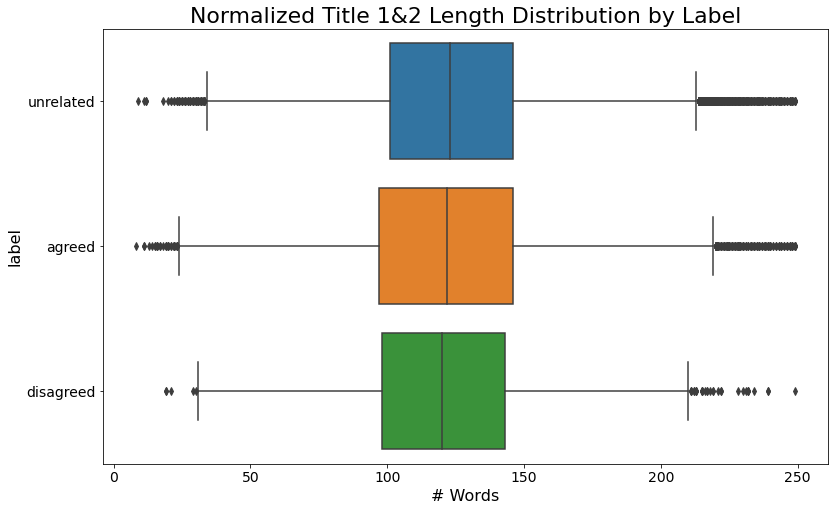

In [82]:
less250 = data_train.title_en_1_2_normalized_length < threshold
plt.figure(figsize=box_size)
ax = sns.boxplot(x='title_en_1_2_normalized_length', y='label', data=data_train[less250])
plt.title("Normalized Title 1&2 Length Distribution by Label", fontsize=t_size)
plt.xlabel(xlab)

The length of the majority text are fairly normally distributed.

<a id='6.2'></a>
### 6.2 Title 1&2 Most Common Words

#### Most Mentioned Key Words

In [83]:
def display_wordcloud(words, title):
    """
    Visualize word cloud (aka, most commonly used words)
    """
    # Create a word cloud object
    wc = WordCloud(
        background_color='white', 
        max_words=50,
        random_state=2020
    )
    # Generate and plot pos wordcloud
    plt.figure(figsize=(15,10))
    plt.imshow(wc.generate(words))
    plt.axis('off')
    plt.title(title, fontsize=22)
    plt.show();

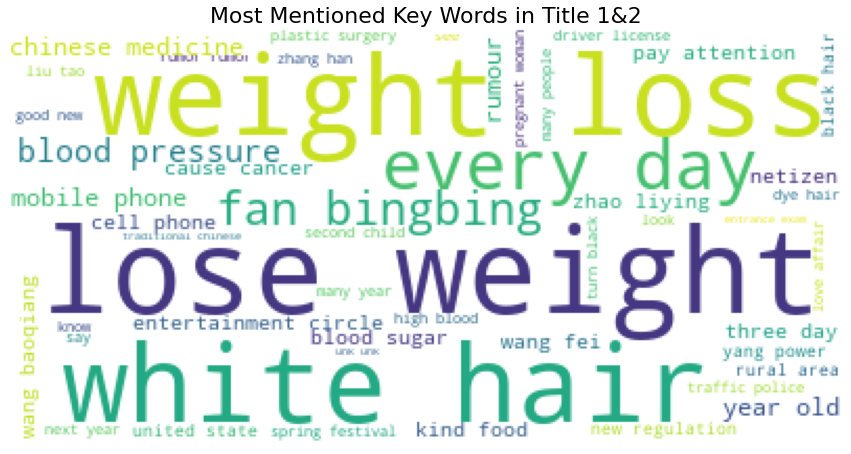

In [84]:
words = ' '.join([text for text in data_train['title_1_2_normalized']])
display_wordcloud(words, 'Most Mentioned Key Words in Title 1&2')

#### Word Length Distibution

In [85]:
word_lengths = [len(w) for w in words.split(' ')]

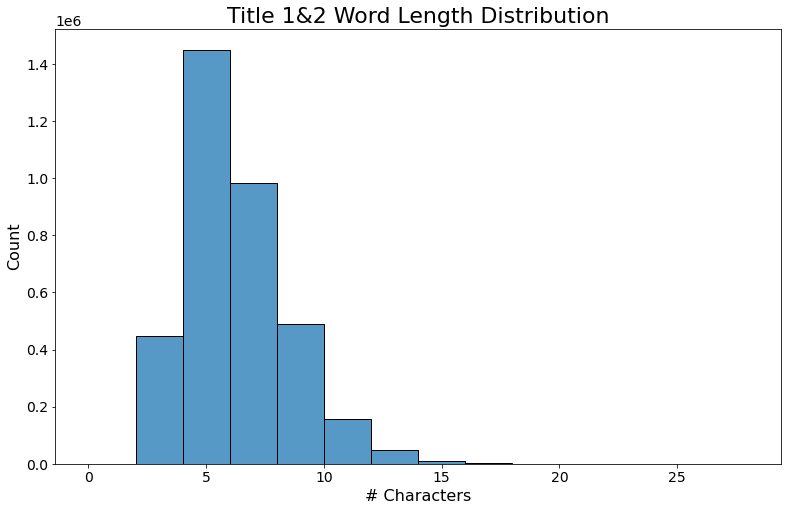

In [86]:
plt.figure(figsize=box_size)
ax = sns.histplot(word_lengths, bins=range(0, 30, 2))
plt.title("Title 1&2 Word Length Distribution", fontsize=t_size)
ax.set_xlabel('# Characters')
plt.show()

<a id='7'></a>
## 7 Selecting Models

<a id='7.1'></a>
### 7.1 Evaluating Random Forest

In [87]:
# Build a random forest object
rf_model = RandomForestClassifier(random_state=random_state)

# K-fold evaluation
res = kfold_cross_validation(rf_model, binary_train_pca, y_train)

Fold 1 f1-score unrelated:0.86 agreed:0.58 disagreed:0.14
Fold 2 f1-score unrelated:0.86 agreed:0.58 disagreed:0.17
Fold 3 f1-score unrelated:0.86 agreed:0.58 disagreed:0.13
Avg. f1-score unrelated:0.86 agreed:0.58 disagreed:0.15


In [88]:
# Create a dataframe to store model performance
df_model = pd.DataFrame()

# Store train data distribution
train_dist = data_train['label'].value_counts() / len(data_train) * 100
df_model = df_model.append([train_dist.tolist()], ignore_index=True)
# Store logistic regression performance on reduced dim vectors
df_model = df_model.append([(df_f1.values)[4,:]], ignore_index=True)

# Store reandom forest performance on reduced dim vectors
df_model = df_model.append([res*100], ignore_index=True)

# Store lstm f1 score taken from lstm notebook
df_model = df_model.append([[89, 76, 47]], ignore_index=True)
# Format the dataframe
df_model.columns = target_names
df_model.index = [
    'Human Performance', 'Logistic Regression', 
    'Random Forest', 'Uni-directional LSTM']
df_model = df_model.sort_values(by='disagreed')
df_model = df_model.astype(int)

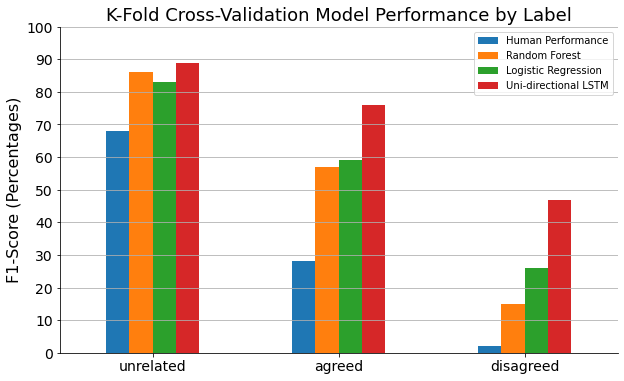

In [89]:
# Plot feature performance
title = "K-Fold Cross-Validation Model Performance by Label"
compare_performance(df_model, title, yticks=True)

In [90]:
# Save model performance
df_model.to_csv(os.path.join(DATA_PATH, 'model_selection.csv'))

`LSTM` has the best performance.

In [91]:
# Release data from memory
del binary_train_pca
del binary_train

In [92]:
# Release data from memory
del data_train
del data_val
del df_train
del df_test